In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import unidecode
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## 3. Feature Engineering

In [2]:
old_df = pd.read_csv('data/cleaned_data.csv')
old_df.head()

,District,Category,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Is Land,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
0,district-2,"Ban nha cap 4 no hau, can goc 2 mat tien duong xe hoi phuong Binh An, Quan 2.",4.0,4.0,East,Renting,Pink book,103.0,103.0,19.00,5.30,NaN,9.80,95.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,district-2,"Ban nha no hau phuong Binh Trung Tay, Quan 2",2.0,2.0,South,Living,Pink book,49.0,59.1,10.46,3.90,2.0,3.85,78.6,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,district-2,"Chinh chu ban nha dep no hau, hem o to, phuong Thanh My Loi, Quan 2.",2.0,2.0,South,Empty,Pink book,114.3,130.7,24.58,4.44,4.0,8.00,70.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,district-2,"Ban nha hem xe hoi, phuong Binh Trung Tay, Tp.Thu Duc",3.0,3.0,South,Living,Pink book,52.4,128.4,11.51,4.57,4.0,4.80,91.6,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,district-2,"Ban nha moi dep, hem xe hoi, phuong Binh Trung Tay, Tp.Thu Duc",2.0,3.0,North,Empty,Pink book,61.0,183.0,15.35,4.00,3.0,5.60,91.8,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


### Remove price outliers

In [3]:
# def remove_outlier(df,column):
#     df_temp = df.copy()
#     # df_temp[column] = np.log(df_temp[column]+1)
#     q1 = df_temp[column].quantile(0.25)
#     q3 = df_temp[column].quantile(0.75)
#     iqr = q3 - q1
#     left_tail = q1-1.5*iqr
#     right_tail = q3+1.5*iqr
#     print(f'Outliers of column {column} are outside the range from {left_tail} to {right_tail}')
    
#     return df_temp[(df_temp[column] < left_tail) | (df_temp[column] > right_tail)].index

# old_df.drop(remove_outlier(old_df,'Price (bil)'),inplace=True)
# old_df.reset_index(drop=True,inplace=True)

In [4]:
def remove_outlier(df,column):
    df_temp = df.copy()
    mean = df_temp[column].mean()
    std = df_temp[column].std()
    left_tail = mean-3*std
    right_tail = mean+3*std
    print(f'Outliers of column {column} are outside the range from {left_tail} to {right_tail}')

    return df_temp[(df_temp[column] < left_tail) | (df_temp[column] > right_tail)].index

old_df.drop(remove_outlier(old_df,'Price (bil)'),inplace=True)
old_df.reset_index(drop=True,inplace=True)

Outliers of column Price (bil) are outside the range from -23.75289117643282 to 40.0192235251703


### Handle categorical variables

In [5]:
#List of categorical variables
categorical_features = list(old_df.select_dtypes(include='object').columns)
categorical_features

['District', 'Category', 'Direction', 'House Status', 'Verification']

In [6]:
#Label encoding 
for feature in categorical_features:
    if feature != 'Category':
        labels_ordered=old_df.groupby([feature])['Price (bil)'].median().sort_values().index
        labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
        old_df[feature]=old_df[feature].map(labels_ordered)

### Log transformation data

- We make a log transformation with features that are very high skewed.

In [7]:
skewed_features = ['Land Area (m2)','Land Used Area (m2)','Length (m)','Width (m)','Alley Width (m)']
df = old_df.copy()
df[skewed_features] = np.log(df[skewed_features]+1)

### Complete missing values

In [8]:
#Make the list of features which has missing values
features_with_na = [col for col in df.columns if (df[col].isnull().sum()>0)]
#Print the features name and the percentage of missing values
for feature in features_with_na:
    print(f'{feature}: {np.round(df[feature].isnull().mean()*100,4)} % missing values')

Bedroom: 2.1144 % missing values
Bathroom: 0.3372 % missing values
Length (m): 0.0048 % missing values
Alley Width (m): 24.0825 % missing values
Floor: 1.2716 % missing values


In [9]:
corr = df.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,District,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Is Land,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
District,1.000000,0.149447,0.148495,0.011868,0.070919,0.001589,0.278004,0.261170,0.228651,0.212164,0.081576,0.280410,0.586879,0.304855,0.106198,0.159954,0.032270,0.041536,0.265977,0.151466,0.221418,0.115102,0.027700,0.167664,0.200417,0.071619,0.020546,0.021793,0.009292,0.064847
Bedroom,0.149447,1.000000,0.941076,0.012122,0.265475,0.015806,0.105560,0.537274,0.116384,0.040653,0.110827,0.382517,0.223176,0.523592,0.133500,0.290690,0.186364,0.018843,0.383469,0.007779,0.003199,0.050229,0.017054,0.014127,0.023408,0.094951,0.075283,0.039757,0.031966,0.004250
Bathroom,0.148495,0.941076,1.000000,0.008514,0.241332,0.011291,0.097792,0.511909,0.101563,0.046978,0.124391,0.374229,0.225420,0.530958,0.123848,0.323006,0.192660,0.020284,0.351018,0.013972,0.004186,0.056997,0.029247,0.007392,0.005926,0.106082,0.081044,0.039257,0.035782,0.004673
Direction,0.011868,0.012122,0.008514,1.000000,0.016321,0.012705,0.036209,0.043803,0.013084,0.048080,0.015715,0.008857,0.013048,0.023491,0.002461,0.018899,0.001807,0.013021,0.045251,0.008977,0.003137,0.013616,0.014078,0.013522,0.027926,0.027917,0.014075,0.005015,0.010081,0.011471
House Status,0.070919,0.265475,0.241332,0.016321,1.000000,0.044447,0.020166,0.285526,0.043359,0.018550,0.005826,0.128323,0.088262,0.135062,0.099867,0.025266,0.017951,0.010965,0.269762,0.035249,0.068629,0.063014,0.028541,0.002070,0.030632,0.037447,0.009877,0.031240,0.033312,0.005893
Verification,0.001589,0.015806,0.011291,0.012705,0.044447,1.000000,0.035486,0.021499,0.080074,0.025665,0.007772,0.053765,0.039948,0.044021,0.025884,0.014726,0.009771,0.007112,0.030732,0.050180,0.045039,0.030471,0.050432,0.046643,0.062310,0.058444,0.103954,0.018045,0.015990,0.000796
Land Area (m2),0.278004,0.105560,0.097792,0.036209,0.020166,0.035486,1.000000,0.157543,0.843195,0.714419,0.314845,0.491369,0.412325,0.289712,0.095958,0.051333,0.046960,0.003135,0.390903,0.071141,0.115758,0.026917,0.043283,0.117378,0.079268,0.017514,0.065189,0.031533,0.035926,0.046384
Land Used Area (m2),0.261170,0.537274,0.511909,0.043803,0.285526,0.021499,0.157543,1.000000,0.084188,0.188434,0.019621,0.271037,0.351974,0.722071,0.193835,0.325741,0.076884,0.046108,0.924881,0.009256,0.028872,0.062471,0.011006,0.088460,0.066600,0.165928,0.103494,0.033290,0.044975,0.033875
Length (m),0.228651,0.116384,0.101563,0.013084,0.043359,0.080074,0.843195,0.084188,1.000000,0.305251,0.349369,0.445252,0.305222,0.223903,0.065011,0.009636,0.039477,0.004698,0.302985,0.072622,0.110644,0.017824,0.024885,0.083431,0.043017,0.017068,0.051100,0.022676,0.027962,0.036554
Width (m),0.212164,0.040653,0.046978,0.048080,0.018550,0.025665,0.714419,0.188434,0.305251,1.000000,0.135373,0.334337,0.299732,0.241283,0.092696,0.079424,0.033565,0.004814,0.324719,0.024315,0.056692,0.029725,0.032146,0.091564,0.073015,0.007556,0.051352,0.016177,0.032354,0.031777


- We found that:
    - Bedroom has a strong relationship with Bathroom
    - Bedroom, Bathroom has a strong relationship with Land Used Area (m2), Floor
    - Length has a strong relationship with Land Area (m2), Width (m)
    - Floor has a strong relationship with Land Used Area (m2), Bedroom, Bathroom, Price/m2 (mil), Have Rooftop
- With these above features, we will use these relationship to complete the missing values.
- With Other missing values, we will drop them.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
def complete_na(data,feature_na,features_pred):
    df = data[features_pred]
    df[feature_na] = data[feature_na]
    df.dropna(inplace=True)
    X_train,X_test,y_train,y_test = train_test_split(df[features_pred],df[feature_na],random_state=3107)
    model = DecisionTreeRegressor()
    model.fit(X_train,y_train)

    return model

In [11]:
#Fill missing values of columns Length (m), Floor, Bathroom, Bedroom
df.loc[df['Length (m)'].isnull(),'Length (m)'] = complete_na(df,feature_na = 'Length (m)', features_pred = ['Land Area (m2)','Width (m)'])\
    .predict(df.loc[df['Length (m)'].isnull(),['Land Area (m2)','Width (m)']])
df.loc[df['Floor'].isnull(),'Floor'] = complete_na(df,feature_na = 'Floor', features_pred = ['Land Used Area (m2)', 'Price/m2 (mil)', 'Have Rooftop'])\
    .predict(df.loc[df['Floor'].isnull(),['Land Used Area (m2)', 'Price/m2 (mil)', 'Have Rooftop']]).astype(int)
df.loc[df['Bathroom'].isnull(),'Bathroom'] = complete_na(df,feature_na = 'Bathroom',features_pred = ['Land Used Area (m2)','Floor'])\
    .predict(df.loc[df['Bathroom'].isnull(),['Land Used Area (m2)','Floor']]).astype(int)
df.loc[df['Bedroom'].isnull(),'Bedroom'] = complete_na(df,feature_na = 'Bedroom',features_pred = ['Bathroom'])\
    .predict(df.loc[df['Bedroom'].isnull(),['Bathroom']]).astype(int)

In [12]:
#Drop others missing values
df.dropna(inplace=True)
old_df = old_df.loc[df.index]
df.reset_index(drop=True,inplace=True)
old_df.reset_index(drop=True,inplace=True)

### Create new feature

In [13]:
#Extract information from header
def return_index_category(df_temp,column,key):
    index = df_temp[df_temp[column].str.lower().str.contains(key)].index
    df_temp.drop(index,inplace=True)

    return index

#Remove anccents
cate = [unidecode.unidecode(i) for i in df['Category']]
df['Category'] = cate

#Create temporary data frame and a list for saving information from header
short_category = np.empty(len(df),dtype='object')
temp = df.copy()

land_index = temp[temp['Is Land']==1].index
short_category[land_index] = 'land'
temp.drop(land_index,inplace=True)

short_category[return_index_category(temp,'Category','shophouse')] = 'shophouse'
short_category[return_index_category(temp,'Category','nha hem')] = 'house'
short_category[return_index_category(temp,'Category','nha mat tien')] = 'townhouse'
short_category[return_index_category(temp,'Category','khach san')] = 'hotel-villa'
short_category[return_index_category(temp,'Category','nha rieng')] = 'house'
short_category[return_index_category(temp,'Category','can ho')] = 'condominium'
short_category[return_index_category(temp,'Category','day tro')] = 'boarding house'
short_category[return_index_category(temp,'Category','phong tro')] = 'boarding house'
short_category[return_index_category(temp,'Category','nha tro ')] = 'boarding house'
short_category[return_index_category(temp,'Category','can goc')] = 'townhouse'
short_category[return_index_category(temp,'Category','nguyen can')] = 'condominium'
short_category[return_index_category(temp,'Category','biet thu')] = 'hotel-villa'
short_category[return_index_category(temp,'Category','nha')] = 'house'
short_category[return_index_category(temp,'Category','chung cu')] = 'condominium'
short_category[temp.index] = 'others'

#Re-assigned to Category column
df['Category'] = short_category
old_df['Category'] = short_category

In [14]:
df['Category'].value_counts()

house             12879
land               1813
condominium         368
boarding house      265
townhouse           261
hotel-villa         133
others               43
Name: Category, dtype: int64

- We found that there are three common types: house, land, town house, hotel-villa, condominium and boarding house. And we will drop others category.

In [15]:
df = df[df['Category'].isin(['house','townhouse','hotel-villa','boarding house','condominium','land'])]
old_df = old_df[old_df['Category'].isin(['house','townhouse','hotel-villa','boarding house','condominium','land'])]
df.reset_index(drop=True,inplace=True)
old_df.reset_index(drop=True,inplace=True)

- We also drop redundant column Is Land

In [16]:
df.drop('Is Land',axis=1,inplace=True)
old_df.drop('Is Land',axis=1,inplace=True)

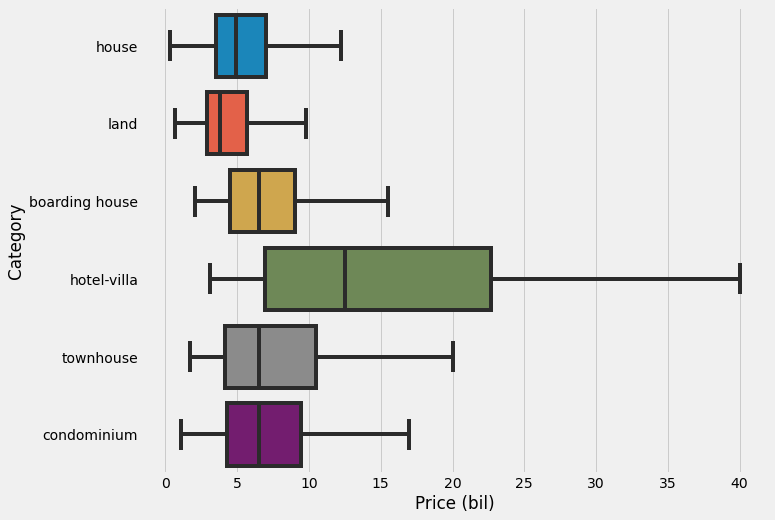

In [17]:
#Relationship between Category and House Price
plt.figure(figsize=(10,8))
sns.boxplot(y='Category',x='Price (bil)',data=df,showfliers=False)
plt.show()

In [18]:
#Encoding Category columns
labels_ordered=df.groupby(['Category'])['Price (bil)'].median().sort_values().index
labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}

old_df['Category'] = old_df['Category'].map(labels_ordered)
df['Category'] = df['Category'].map(labels_ordered)

### Cluster Analysis and PCA

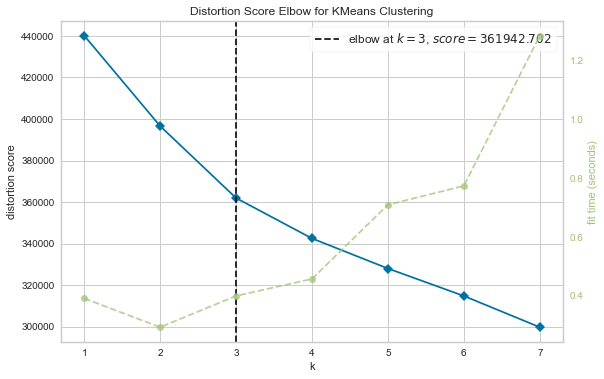

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

cluster_df = df.copy()
cluster_df = cluster_df.select_dtypes(exclude='O')

#Scale data
scaler = StandardScaler()
scale_df = pd.DataFrame(scaler.fit_transform(cluster_df),columns=cluster_df.columns)
X = scale_df.drop(['Price (bil)','Price/m2 (mil)'],axis=1)

#Find the best k cluster
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,8))
visualizer.fit(X)
visualizer.show()

In [20]:
#Use k = 3
kmeans = KMeans(n_clusters=3,max_iter=500)
kmeans.fit(X)
#Segmentation
old_df['Cluster'] = kmeans.predict(X)

In [21]:
#Analysis
old_df.groupby(['Cluster']).mean()

,District,Category,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.912906,1.175275,3.359489,3.064403,2.491030,1.646950,2.015114,64.688018,118.449027,13.783575,4.607908,4.166542,5.899003,105.153170,2.238043,0.251386,0.224095,0.003371,0.010003,0.981733,0.959987,0.296510,0.751549,0.674350,0.615636,0.550179,0.170490,0.064478,0.234859,0.070675
1,5.295029,0.034741,0.057527,0.044433,2.336718,1.027258,2.031534,243.408605,4.199786,22.675167,7.998099,4.892544,5.550621,44.768318,0.035275,0.002138,0.000000,0.000000,0.000000,0.824158,0.795831,0.163014,0.620524,0.663816,0.540353,0.171032,0.076430,0.028327,0.119188,0.080706
2,12.970329,1.149860,3.080114,2.789918,2.423135,1.487422,2.009675,51.078951,106.777381,12.040835,4.294414,3.817869,6.665481,144.415739,2.395770,0.240593,0.231348,0.003225,0.013760,0.325736,0.150935,0.069447,0.204257,0.024511,0.027306,0.017631,0.088153,0.006880,0.029456,0.022576


- We found that the group 0 and group 2 are quite similar in terms of attributes and are difficult to distinguish. On the contrary, group 1 is quite different from the above 2 groups.

In [22]:
#PCA for visualization
from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X))
pca_df['Cluster'] = old_df['Cluster']
pca_df['Category'] = df['Category']

pca_df.head()

,0,1,Cluster,Category
0,-0.792881,0.643143,0,1
1,-2.182848,1.402425,0,1
2,-0.352268,2.077782,0,1
3,-0.697849,1.390988,0,1
4,2.425664,0.244225,2,1


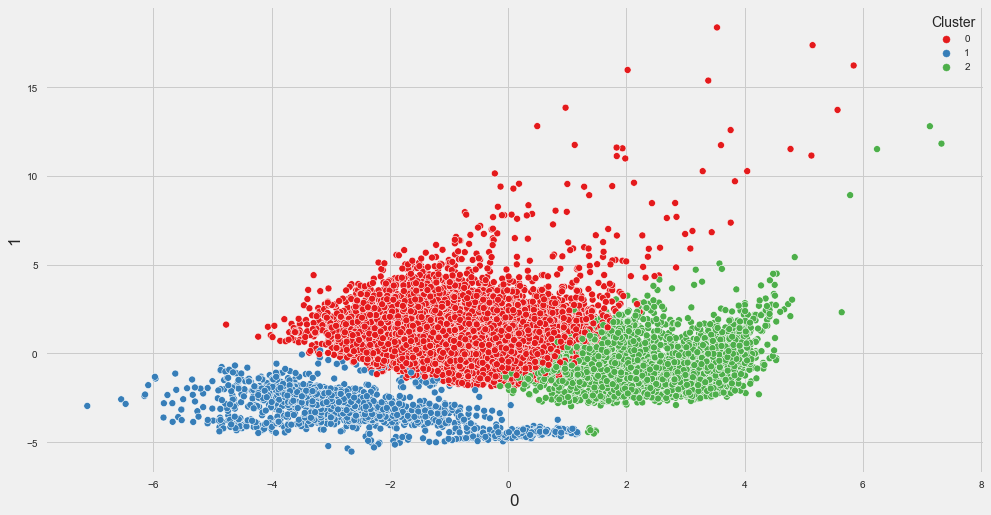

In [23]:
#PCA based on KMeans
plt.figure(figsize=(15,8))
sns.scatterplot(x=0,y=1,data=pca_df,hue=pca_df['Cluster'],palette='Set1')
plt.show()

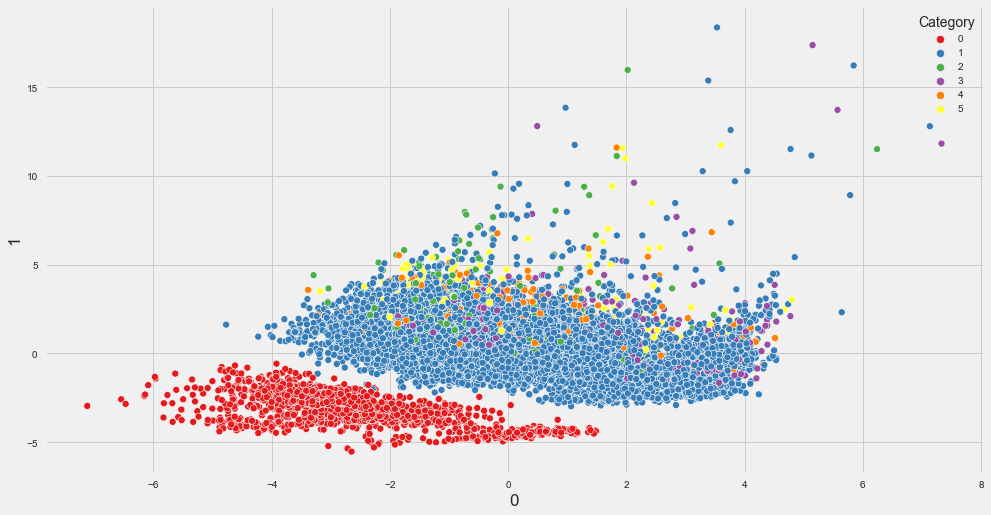

In [24]:
#PCA based on Category
plt.figure(figsize=(15,8))
sns.scatterplot(x=0,y=1,data=pca_df,hue=df['Category'],palette='Set1')
plt.show()

- We will split the data into data for Land and data for others.

In [25]:
land_df = df.loc[df['Category']==0].reset_index(drop=True)
home_df = df.loc[df['Category']!=0].reset_index(drop=True)

## 4. Feature Selection

### Drop redundant features

In [26]:
land_df.describe().loc[['std']]

,District,Category,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
std,4.888999,0.0,0.0,0.0,0.945861,0.177804,0.233024,0.908899,0.0,0.467086,0.50885,0.350916,5.054467,28.643234,0.0,0.0,0.0,0.0,0.0,0.386873,0.408309,0.371211,0.483261,0.474685,0.498162,0.377563,0.266138,0.168506,0.326619,0.273035


In [27]:
home_df.describe().loc[['std']]

,District,Category,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
std,5.628776,0.647418,2.761775,2.761128,0.792555,0.717725,0.155084,0.608962,0.642515,0.425807,0.278984,0.372072,4.377421,60.676411,0.906642,0.431291,0.417983,0.057421,0.105324,0.425492,0.462662,0.4141,0.495525,0.498233,0.493251,0.482914,0.349604,0.20719,0.371551,0.227168


- We will drop some features that have zeros standard deviation.

In [28]:
land_df.drop([
    'Category','Bedroom','Bathroom','Land Used Area (m2)','Floor','Have Mezzanine','Have Rooftop','Have Basement','Have Attic'
],axis=1,inplace=True)

### Drop highly correlated features

- We will drop features that have correlation coefficient larger than 0.7

In [29]:
corr = land_df.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,District,Direction,House Status,Verification,Land Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
District,1.000000,0.151808,0.014040,0.113271,0.310844,0.279743,0.264714,0.040101,0.208892,0.688167,0.033118,0.075473,0.098240,0.163266,0.015700,0.228064,0.233895,0.011734,0.040604,0.029004,0.168736
Direction,0.151808,1.000000,0.013083,0.019981,0.162486,0.123440,0.151098,0.174288,0.058518,0.171664,0.059137,0.040286,0.082084,0.002921,0.010782,0.183459,0.075545,0.051773,0.021862,0.058210,0.059719
House Status,0.014040,0.013083,1.000000,0.012357,0.052244,0.027162,0.056316,0.018591,0.089933,0.062572,0.004753,0.004600,0.000526,0.010511,0.002164,0.034882,0.023057,0.008864,0.000965,0.022507,0.033182
Verification,0.113271,0.019981,0.012357,1.000000,0.199200,0.161394,0.180308,0.064026,0.102088,0.167571,0.019047,0.019765,0.000602,0.038984,0.027423,0.025661,0.004435,0.001247,0.008132,0.003244,0.029304
Land Area (m2),0.310844,0.162486,0.052244,0.199200,1.000000,0.840833,0.866602,0.138301,0.537760,0.543385,0.024479,0.002243,0.048905,0.085328,0.062192,0.162236,0.109305,0.046126,0.039122,0.068163,0.046886
Length (m),0.279743,0.123440,0.027162,0.161394,0.840833,1.000000,0.510737,0.087922,0.434707,0.484191,0.004740,0.016147,0.050497,0.071847,0.024821,0.149608,0.070650,0.040492,0.002414,0.046813,0.051104
Width (m),0.264714,0.151098,0.056316,0.180308,0.866602,0.510737,1.000000,0.143320,0.462111,0.446965,0.045564,0.014064,0.038178,0.089814,0.085992,0.134133,0.109821,0.038424,0.019818,0.074196,0.028602
Alley Width (m),0.040101,0.174288,0.018591,0.064026,0.138301,0.087922,0.143320,1.000000,0.100377,0.194208,0.017584,0.028100,0.068929,0.060791,0.021527,0.114412,0.099153,0.124177,0.012789,0.126125,0.019316
Price (bil),0.208892,0.058518,0.089933,0.102088,0.537760,0.434707,0.462111,0.100377,1.000000,0.172486,0.050986,0.048109,0.033971,0.028969,0.048873,0.018693,0.038246,0.033664,0.082586,0.023611,0.007011
Price/m2 (mil),0.688167,0.171664,0.062572,0.167571,0.543385,0.484191,0.446965,0.194208,0.172486,1.000000,0.064274,0.114472,0.097658,0.077385,0.060294,0.118639,0.146725,0.075006,0.023993,0.066778,0.026072


In [30]:
land_drop = ['Length (m)','Width (m)','Near School']

In [31]:
corr = home_df.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,District,Category,Bedroom,Bathroom,Direction,House Status,Verification,Land Area (m2),Land Used Area (m2),Length (m),Width (m),Alley Width (m),Price (bil),Price/m2 (mil),Floor,Have Mezzanine,Have Rooftop,Have Basement,Have Attic,Near Market,Near School,Near Hospital,Near Center,Near Frontage,Securities Space,Comfortable Space,Have Car Park,Larger Rear,Alley Surface,Urgent Sale
District,1.000000,0.054900,0.048129,0.059823,0.025049,0.015702,0.018254,0.180754,0.044551,0.153880,0.095748,0.053372,0.330478,0.622861,0.210695,0.051754,0.120383,0.015832,0.039451,0.212316,0.282348,0.085478,0.077759,0.202588,0.298807,0.180580,0.000170,0.003245,0.031304,0.065525
Category,0.054900,1.000000,0.134381,0.147450,0.014444,0.036988,0.000374,0.135192,0.139622,0.076117,0.150102,0.100495,0.217401,0.062106,0.057623,0.006674,0.025657,0.050953,0.020058,0.009719,0.010128,0.015567,0.029167,0.027593,0.017085,0.034109,0.055891,0.019788,0.070539,0.053588
Bedroom,0.048129,0.134381,1.000000,0.927202,0.009224,0.189033,0.004084,0.354721,0.515060,0.288090,0.243177,0.187787,0.457583,0.080537,0.380182,0.061546,0.243569,0.152650,0.000686,0.011345,0.020744,0.030432,0.025802,0.042049,0.016071,0.041527,0.056568,0.039197,0.040204,0.014170
Bathroom,0.059823,0.147450,0.927202,1.000000,0.007598,0.174068,0.001493,0.323247,0.518931,0.256053,0.233471,0.198317,0.457446,0.111996,0.417604,0.060825,0.280598,0.152739,0.000956,0.018600,0.021205,0.038552,0.039973,0.042000,0.027861,0.056939,0.061430,0.043308,0.046793,0.009923
Direction,0.025049,0.014444,0.009224,0.007598,1.000000,0.005669,0.014355,0.004504,0.005663,0.009508,0.004470,0.002003,0.002575,0.015116,0.000465,0.017847,0.011649,0.002420,0.012907,0.026680,0.015140,0.004070,0.023109,0.023723,0.021358,0.023005,0.008898,0.004180,0.002304,0.003888
House Status,0.015702,0.036988,0.189033,0.174068,0.005669,1.000000,0.029796,0.164100,0.098114,0.138789,0.102120,0.050337,0.094572,0.069424,0.056024,0.049850,0.030451,0.029262,0.003474,0.050657,0.101565,0.048618,0.018510,0.061840,0.078789,0.011481,0.013842,0.023705,0.043003,0.019713
Verification,0.018254,0.000374,0.004084,0.001493,0.014355,0.029796,1.000000,0.030285,0.004555,0.032291,0.014253,0.003032,0.010675,0.018538,0.033756,0.011490,0.017347,0.005049,0.013738,0.012136,0.002666,0.012839,0.003612,0.014406,0.018797,0.014409,0.013182,0.007846,0.017797,0.017727
Land Area (m2),0.180754,0.135192,0.354721,0.323247,0.004504,0.164100,0.030285,1.000000,0.669659,0.833970,0.599242,0.362843,0.563950,0.423554,0.109000,0.007370,0.042529,0.044597,0.001097,0.101177,0.127742,0.005902,0.045015,0.151952,0.116324,0.095883,0.118605,0.054797,0.038936,0.040109
Land Used Area (m2),0.044551,0.139622,0.515060,0.518931,0.005663,0.098114,0.004555,0.669659,1.000000,0.579598,0.380079,0.436621,0.619477,0.007298,0.470408,0.033718,0.398867,0.086563,0.023284,0.044873,0.053960,0.035321,0.026572,0.085972,0.044599,0.099693,0.108064,0.027269,0.072245,0.016843
Length (m),0.153880,0.076117,0.288090,0.256053,0.009508,0.138789,0.032291,0.833970,0.579598,1.000000,0.151065,0.377140,0.453317,0.343592,0.087952,0.005150,0.061487,0.032941,0.002101,0.086646,0.111427,0.005429,0.025832,0.124220,0.085980,0.079545,0.100770,0.040452,0.046504,0.032736


In [32]:
home_drop = ['Bedroom','Length (m)','Near School']

In [33]:
land_df.drop(land_drop,axis=1,inplace=True)
home_df.drop(home_drop,axis=1,inplace=True)

### Features importance

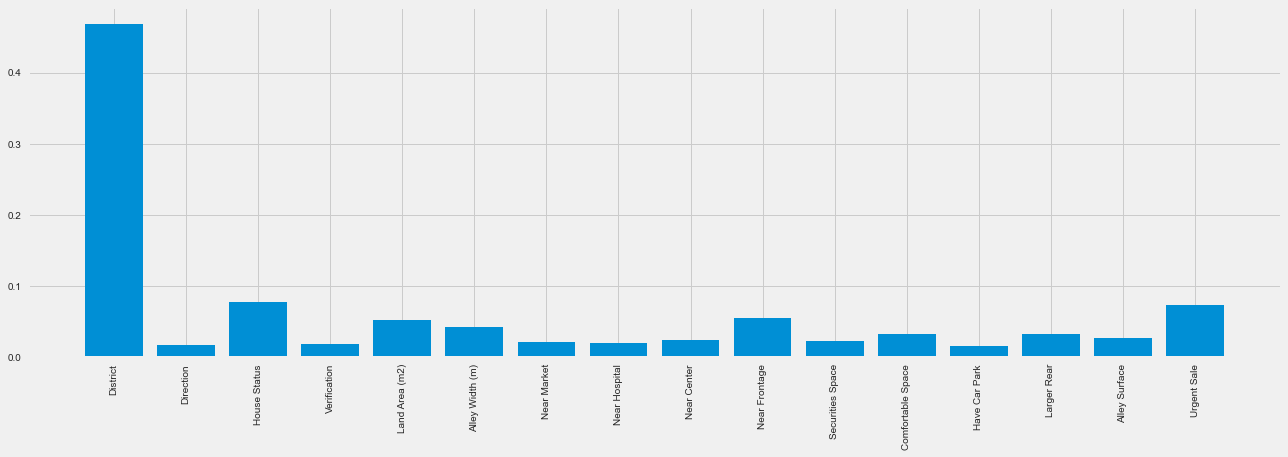

In [34]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

X = land_df.drop(['Price (bil)','Price/m2 (mil)'],axis=1)
y = land_df['Price/m2 (mil)']

model = XGBRegressor()
model.fit(X,y)

plt.figure(figsize=(20,6))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(ticks=range(len(list(X.columns))),labels = list(X.columns),rotation=90)
plt.show()

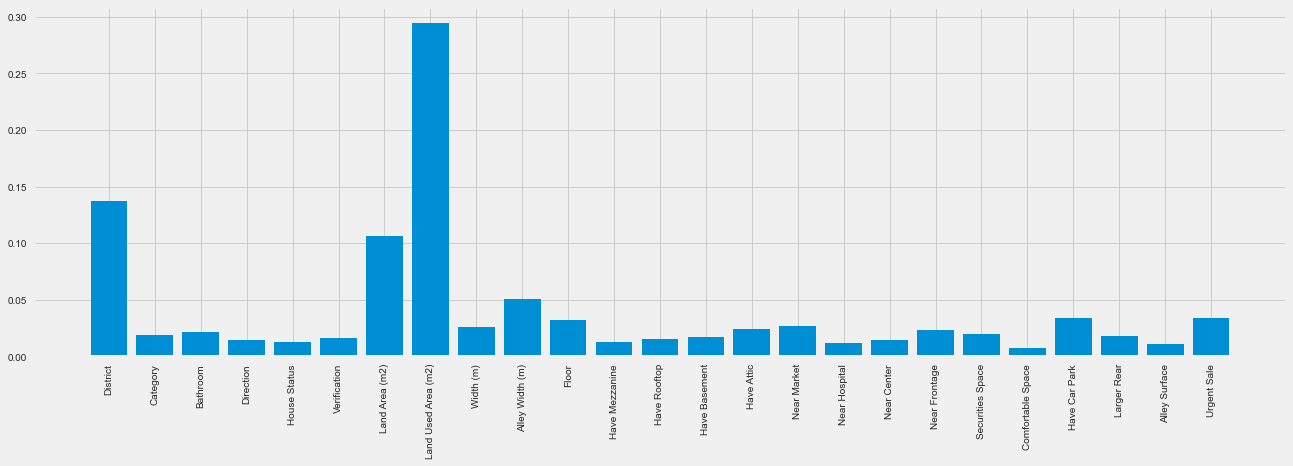

In [35]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

X = home_df.drop(['Price (bil)','Price/m2 (mil)'],axis=1)
y = home_df['Price (bil)']

model = XGBRegressor()
model.fit(X,y)

plt.figure(figsize=(20,6))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(ticks=range(len(list(X.columns))),labels = list(X.columns),rotation=90)
plt.show()

### Remove anomaly observations

In [36]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=3107,max_features=27)
clf.fit(home_df)

home_df['Anomalies'] = clf.predict(home_df)
home_df = home_df[home_df['Anomalies']==1]
home_df.drop('Anomalies',axis=1,inplace=True)
home_df.reset_index(drop=True,inplace=True)

In [38]:
home_df.to_csv('data/train.csv',index=False)